In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tesla-stock-data/TSLA.csv


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error

from IPython.core.display import display, HTML

from datetime import datetime

2024-08-17 15:53:05.337928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 15:53:05.338129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 15:53:05.510237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/tesla-stock-data/TSLA.csv")


In [4]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
1,1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2,2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
3,3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
4,4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500


In [5]:
df.describe()

,Unnamed: 0,Open,High,Low,Close,Volume
count,3534.000000,3534.000000,3534.000000,3534.000000,3534.000000,3.534000e+03
mean,1766.500000,74.997811,76.642865,73.249666,74.985912,9.694511e+07
std,1020.322253,102.281381,104.556354,99.811577,102.217353,7.877581e+07
min,0.000000,1.076000,1.108667,0.998667,1.053333,1.777500e+06
25%,883.250000,11.448667,11.753834,11.191166,11.532334,4.749600e+07
50%,1766.500000,17.417334,17.645333,17.064000,17.400333,8.216325e+07
75%,2649.750000,159.177502,161.312500,153.632500,158.180004,1.228650e+08
max,3533.000000,411.470001,414.496674,405.666656,409.970001,9.140820e+08


In [6]:
df.shape

(3534, 7)

In [7]:
df.isnull().sum(axis=0)

Unnamed: 0    0
Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
dtype: int64

In [8]:
df.drop(df.columns[0], inplace=True, axis=1)


In [9]:
for i in df.columns[1:5]:
    display(HTML("<h2>{}</h2>".format(i)))
    fig = px.line(df, y=i, x=df.columns[0])
    fig.show()

In [10]:
def convert_date(x):
    date = datetime.strptime(x, "%Y-%m-%d")
    return [date.month, date.year]



months = ["January", "February", "March", "April",
         "May", "June", "July", "August",
         "September", "October", "November", "December"]

In [11]:
df["Year"] = df["Date"].apply(lambda x: convert_date(x)[1])
df["Month"] = df["Date"].apply(lambda x: convert_date(x)[0])

In [12]:
nums = df.columns[1:5]


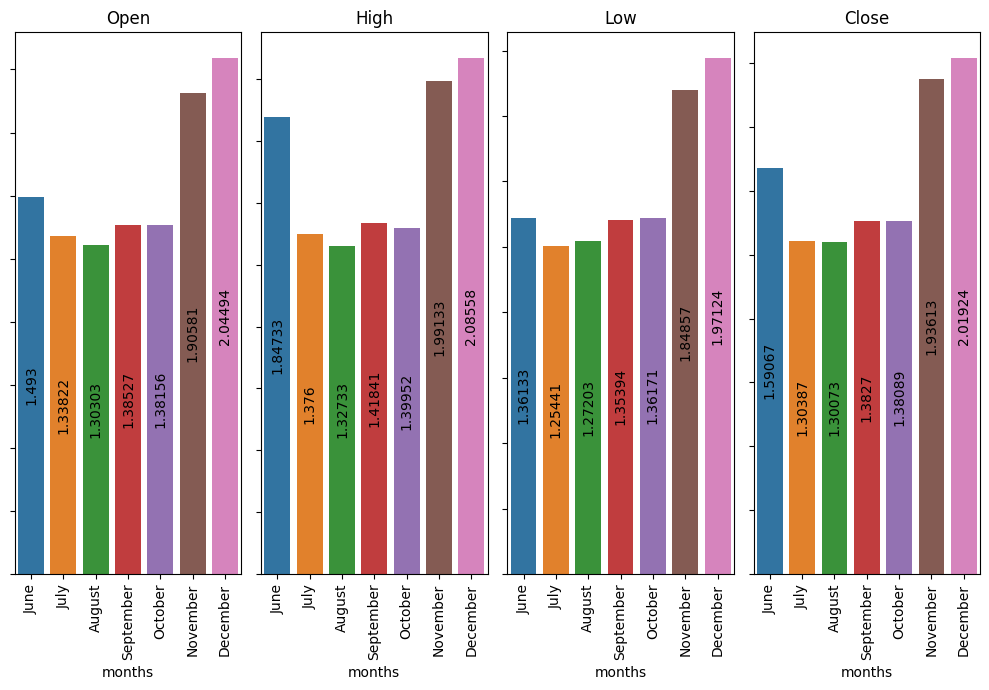

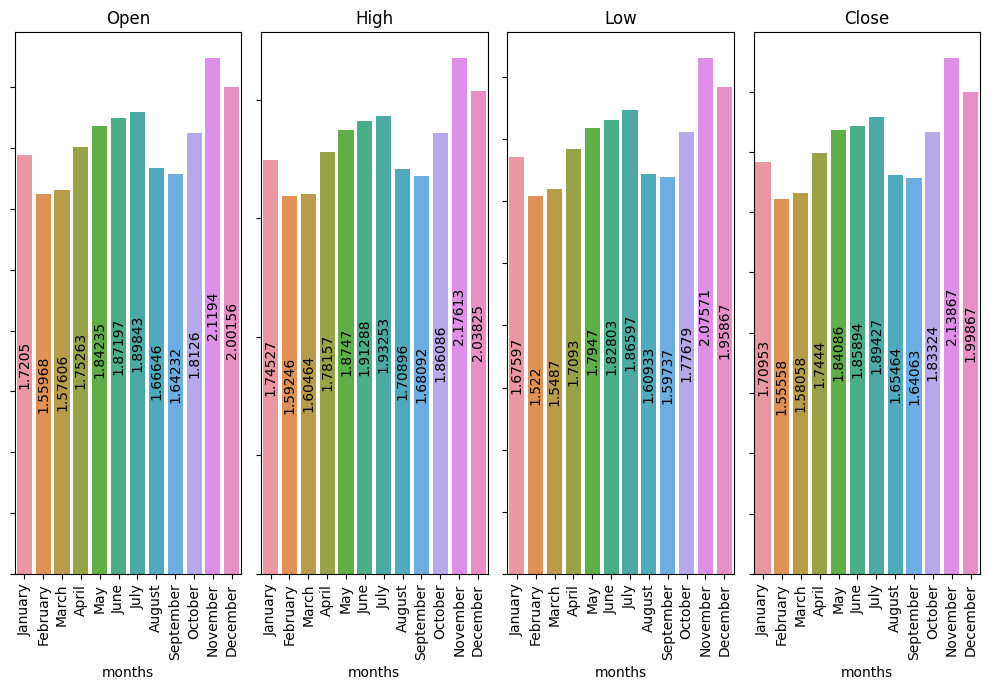

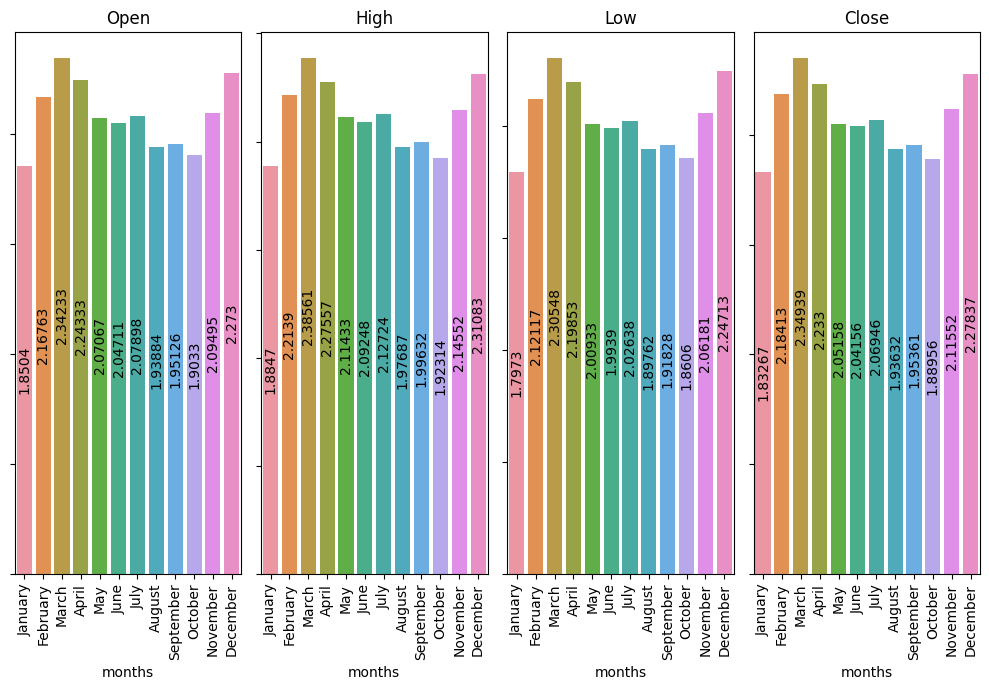

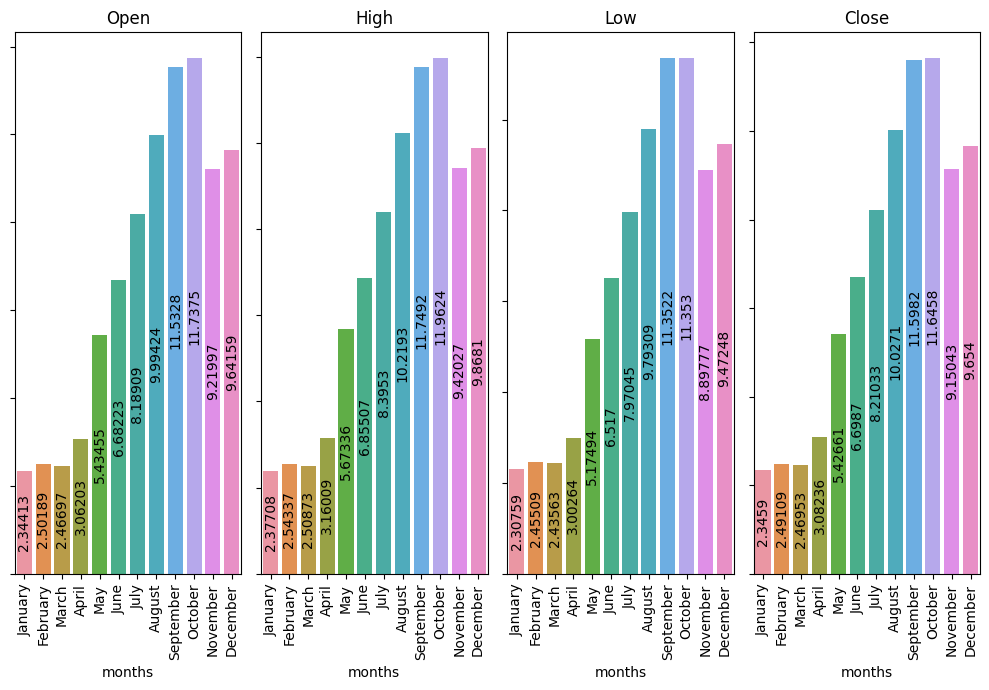

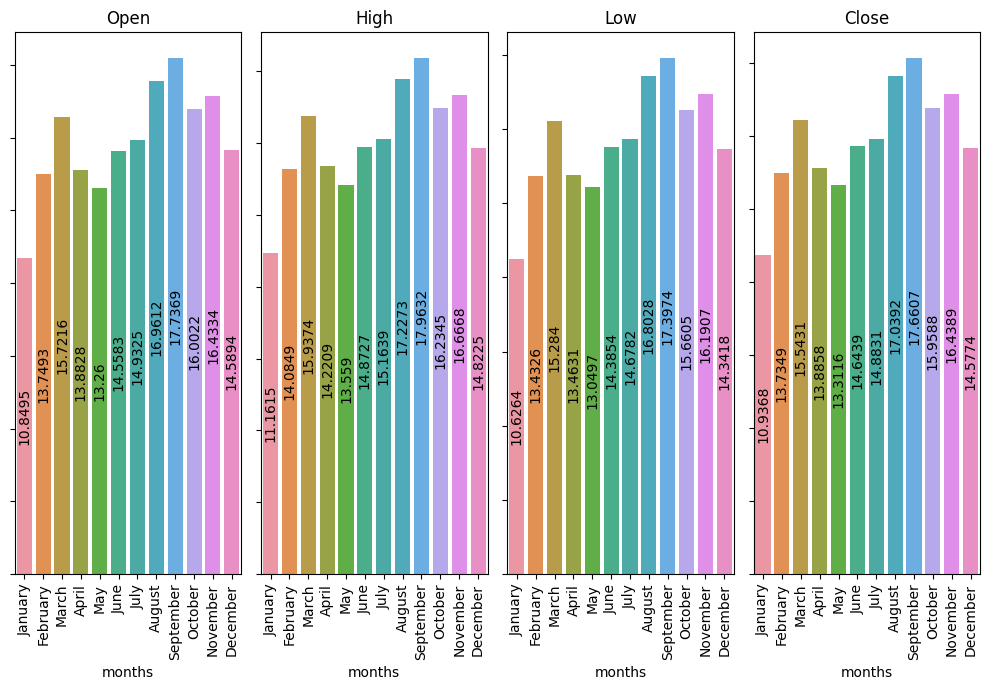

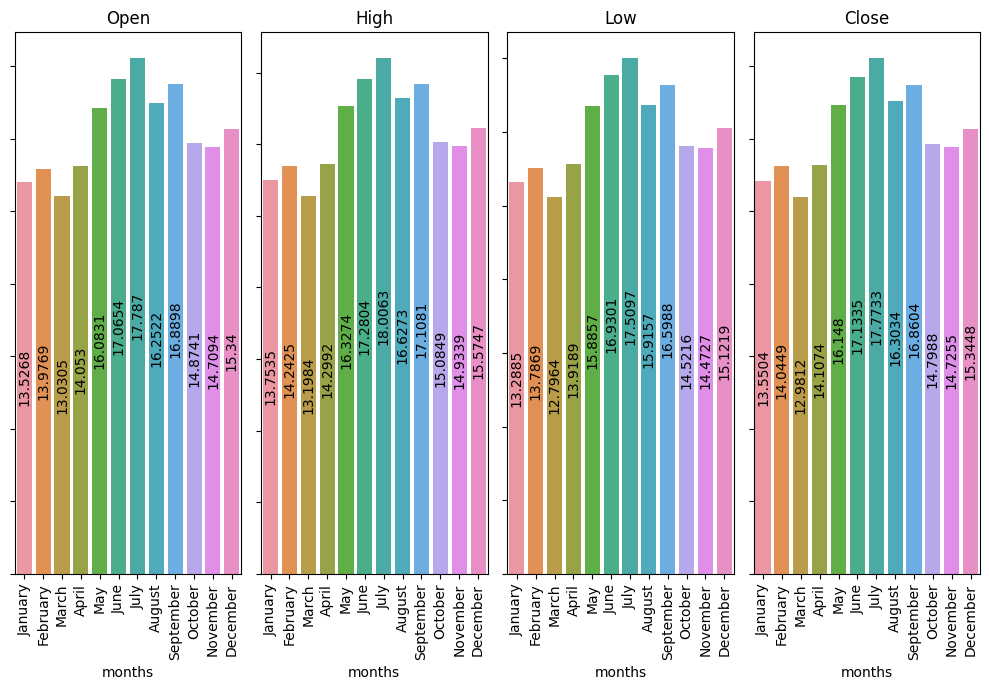

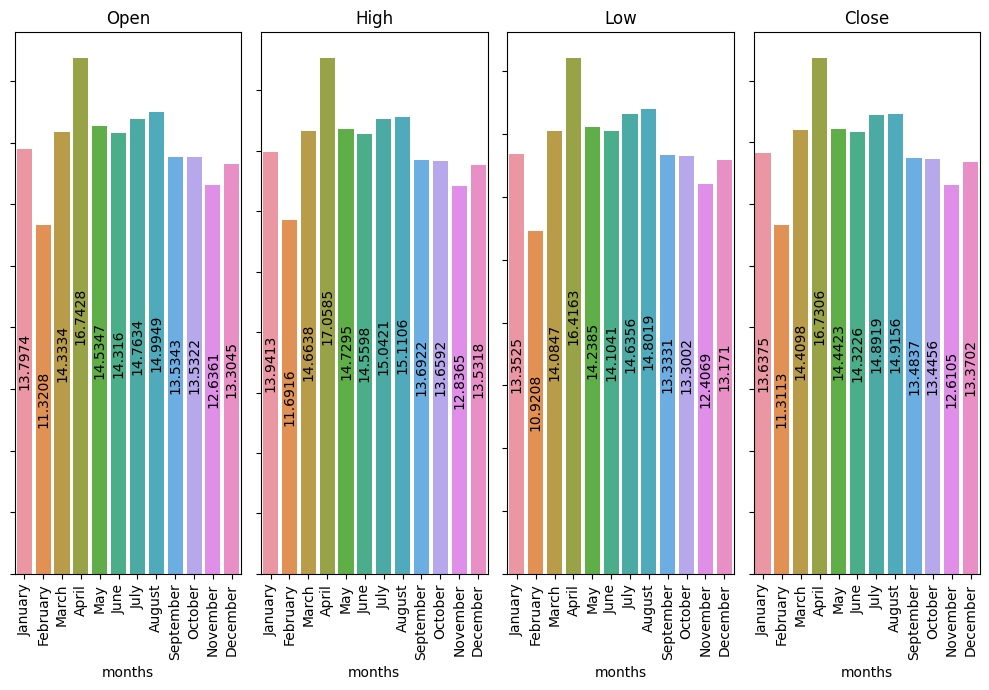

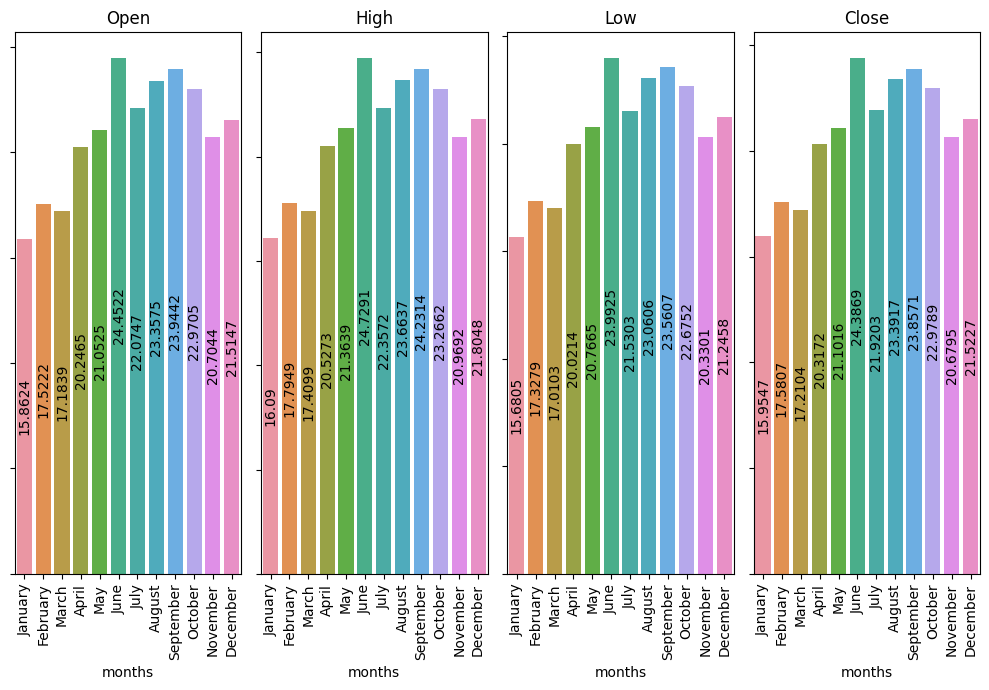

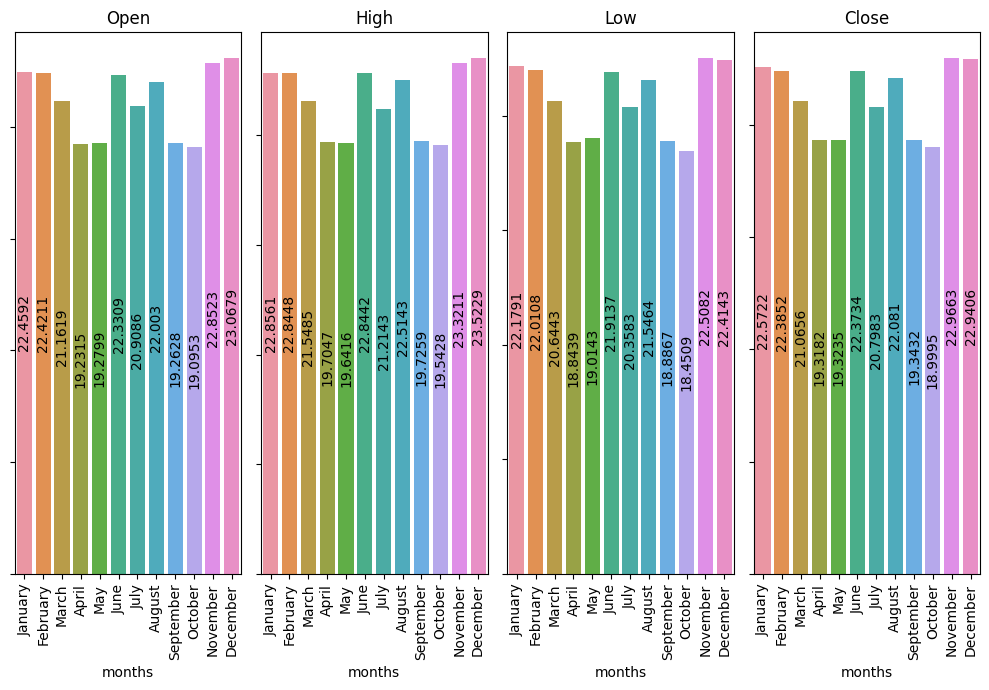

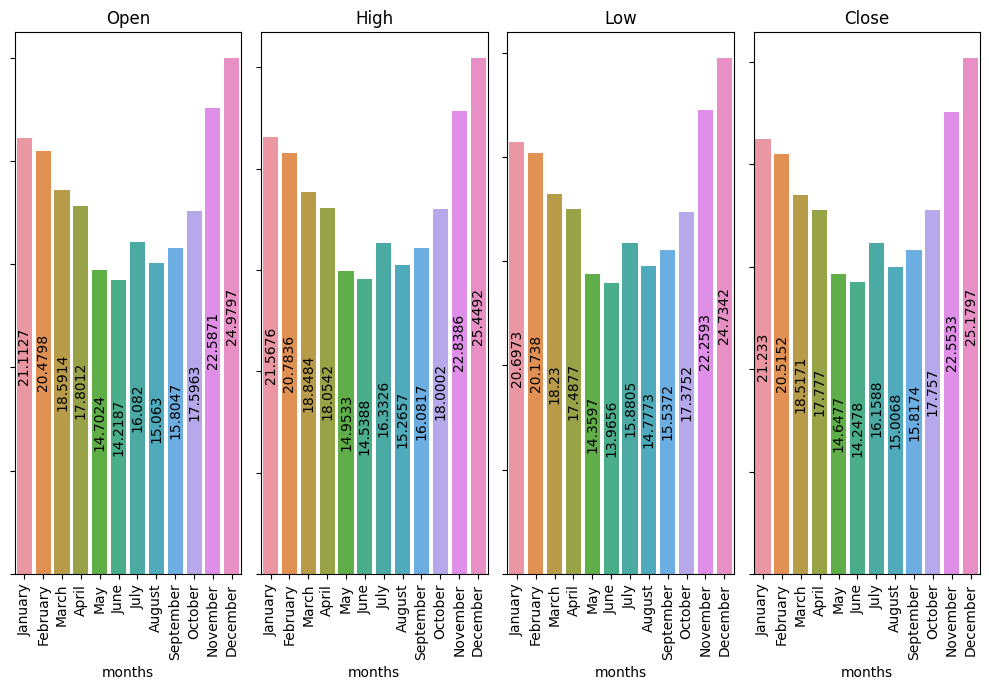

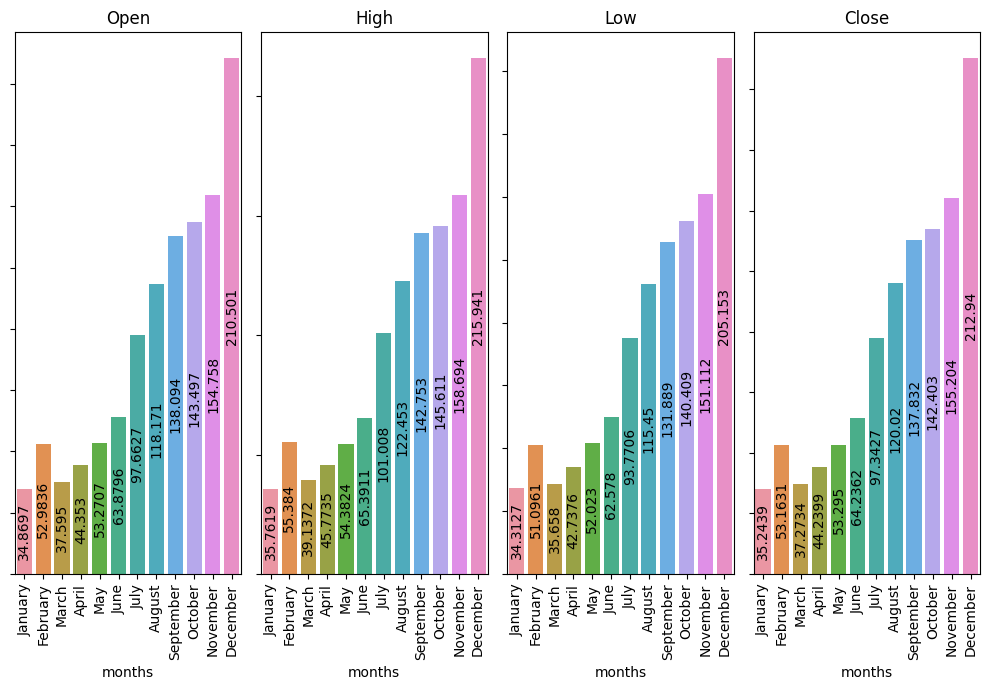

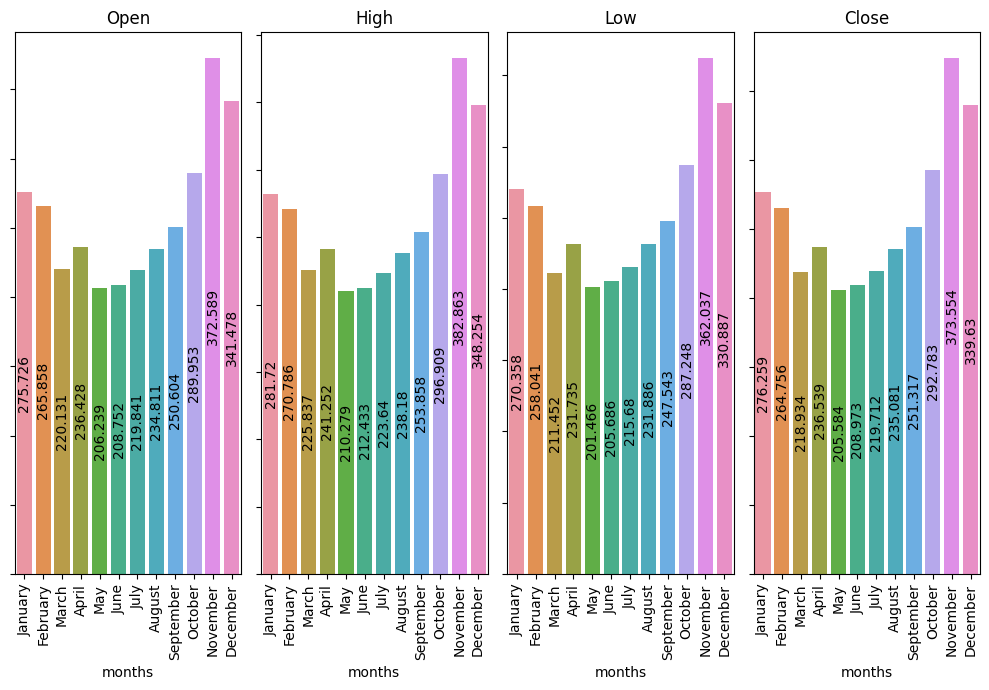

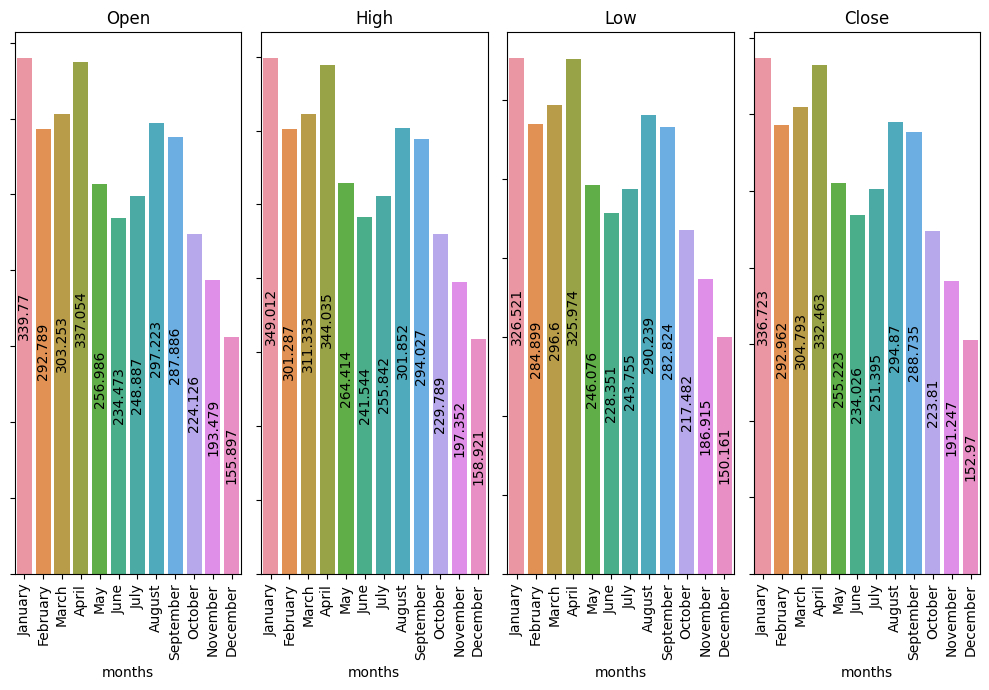

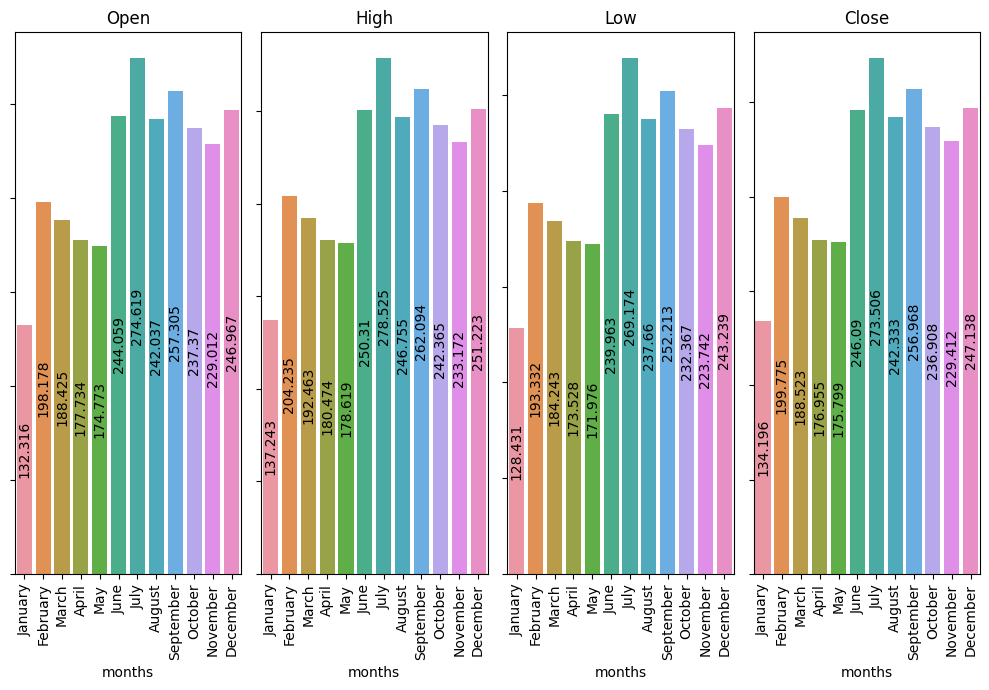

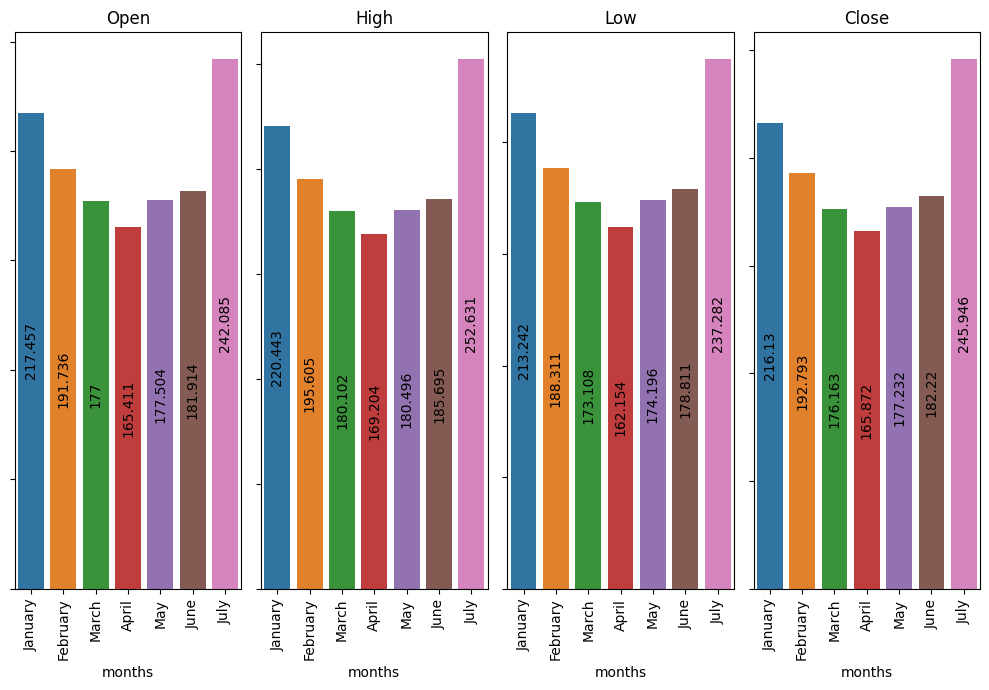

In [13]:

years = df["Year"].unique()

for i in sorted(years):
    display(HTML("<h2>Monthly average stock prices for {}</h2>".format(i)))
    temp_df = df[df["Year"] == i]
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
    grouped = temp_df.groupby("Month")
    for k, j in enumerate(nums):
        mean = pd.DataFrame(grouped[j].mean())
        mean = mean.sort_index(ascending=True)
        dd = {"month": [], j: []}
        for l in range(mean.shape[0]):
            dd["month"] += [months[mean.index[l]-1]]
            dd[j] += [mean.iloc[l, 0]]
        dd = pd.DataFrame(dd)
        
        sns.barplot(x=dd.iloc[:, 0].values, y=dd.iloc[:, 1].values, ax=axes[k])
        for container in axes[k].containers:
            axes[k].bar_label(container, label_type="center", rotation=90)
        axes[k].set_xticklabels(axes[k].get_xticklabels(), rotation=90)
        axes[k].set_title(j)
        axes[k].set_ylabel("")
        axes[k].set_xlabel("months")
        axes[k].set_yticklabels(())
        
    plt.tight_layout()
    plt.show()

In [14]:
data = df[nums].copy()


In [15]:
cols = data.columns

for i in cols:
    dname = "Target "+i
    data[dname] = data[i].shift(-1)

In [16]:
data.dropna(inplace=True)


In [17]:
sc = MinMaxScaler()
scaled = sc.fit_transform(data.values)

In [18]:
x = []

backcandles = 1
for j in range(4):
    x.append([])
    for i in range(backcandles, scaled.shape[0]):
        x[j].append(scaled[i-backcandles:i, j])

x = np.moveaxis(x, [0], [2])

x, yi = np.array(x), np.array(scaled[backcandles:, -4:])
y = np.reshape(yi, (len(yi), 4))

In [19]:
split = int(len(x)*0.8)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [20]:
lstm_input = tf.keras.layers.Input(shape=(backcandles, 4), name="lstm_input")
inputs = tf.keras.layers.LSTM(150, name="first_layer")(lstm_input)
inputs = tf.keras.layers.Dense(4, name="dense_layer", activation="linear")(inputs)
model = tf.keras.models.Model(inputs=lstm_input, outputs=inputs)
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss="mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, 1, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_layer (LSTM)              │ (None, 150)            │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 4)              │           604 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,604 (365.64 KB)

 Trainable params: 93,604 (365.64 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(x=x_train, y=y_train, batch_size=16, epochs=10, validation_split=0.1)


Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.4419e-04 - val_loss: 9.7364e-04
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2471e-05 - val_loss: 0.0011
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0222e-05 - val_loss: 0.0013
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2353e-05 - val_loss: 7.7357e-04
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0464e-05 - val_loss: 7.7933e-04
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5248e-06 - val_loss: 8.5028e-04
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1511e-05 - val_loss: 0.0010
Epoch 8/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3068e-05 - val_loss: 0.0014
Epoch 9/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2385e-05 - val_loss: 8.0215e-04
Epoch 10/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1933e-05 - val_loss: 6.7087e-04


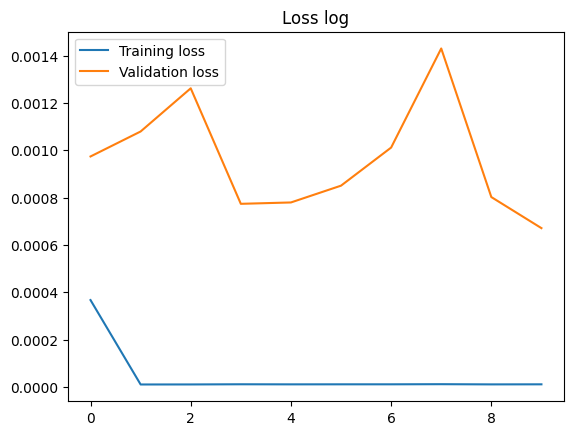

In [22]:
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.title("Loss log")
plt.show()

In [23]:
y_pred = model.predict(x_test)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [24]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("r2: ", r2)

MSE:  0.0010888982395928204
r2:  0.9517039429716412


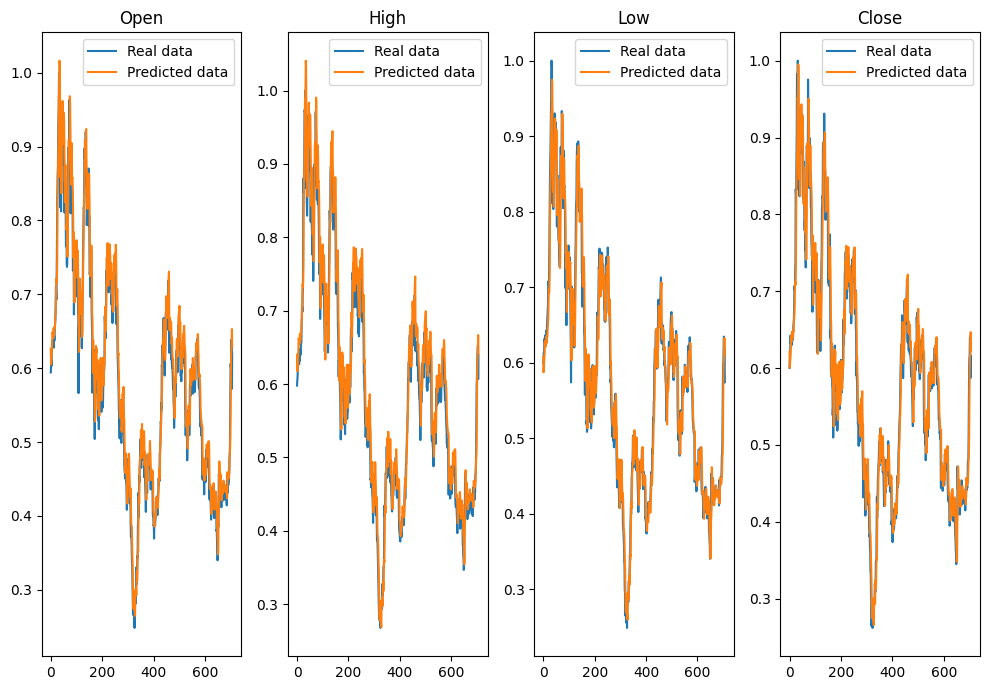

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 7))
for i in range(4):
    axes[i].plot(y_test[:, i], label="Real data")
    axes[i].plot(y_pred[:, i], label="Predicted data")
    axes[i].legend()
    axes[i].set_title(nums[i])
plt.tight_layout()
plt.show()